### In this section:
* Thoughts on word embeddings as a means of representing text
* Integrating your embeddings into SpaCy
* Thoughts on LSTMs for classification
* Integrating your classifier into SpaCy
* Visualizing your embeddings[if time permits]
* Visualizing your model[if time permits]


### How to represent words for NLP
* motivator on why bag of words/ one hot encoding is bad
    * curse of dimensionality, sparsity, ignores context, new words, etc.
* Word vectors
    * distributional hypothesis 
        * describing the landscape of models as using different types of "context"   
        * count and predictive approachs [<a href="#note1">note.</a>]
        * larger context: semantic relatedness (e.g. “boat” – “water”)
        * smaller context: semantic similarity (e.g. “boat” – “ship”)
    * quick overview on methods
    * SVD on doc/word matrices
    * SVD on co-occurance matrices with window
    
    * some issues:
        * large matrices!
        * expensive to SVD (quadratic time)
        * Sparse
    * Glove
    * word2vec: make word vectors the parameters of a model with the objective of defining local context.
    * go over word2vec in a little more detail
        * skip gram
        * cbow
        * negative sampling
    * word embeddings in python:
        * sklearn/pydsm + numpy (vectorizers + matrix decompositions)
        * gensim (word2vec)
* Neural models 

        
        
* Inspecting results of word embeddings:
    * self organizing maps
* Validating word vectors:
    * intrinsic vs extrinsic
    
* A note on NNs:
    * transferable features in shallow parts of a network, theres an analogy their with word2vec (shallow networks).

### Exercise 1:
Train your own word2vec model using dataset, and load those vectors into spacy. Visually inspect the results of the vector as a self organizing map.

#### Gotchas and notes:
* Due to the way the binary vector files are read and written, only single word lexemes can be mapped to a vector.

In [3]:
#!pip install spacy >> ../spacy-install.log
#!python -m spacy download en >> ../spacy-download.log
#!pip install gensim >> ../gensim-log.txt
#!pip install tensorflow >> ../tensorflow-log.txt
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups
import spacy

nlp = spacy.load('en')
dataset = fetch_20newsgroups()
corpus = dataset.data

In [4]:
#!pip install skater >> skaterlog.txt
from spacy.tokens import Doc
import spacy
from spacy.matcher import Matcher
from spacy.attrs import ORTH, IS_PUNCT
from skater.util.progressbar import ProgressBar
        
class TextProcesser(object):
    
    def __init__(self, nlp=None):
        self.nlp = nlp or spacy.load('en')
        
    def __call__(self, corpus, merge_ents=False, matcher=None):
        p = ProgressBar(len(corpus))
        for doc in self.nlp.pipe(corpus, parse=False, tag=bool(merge_ents)):
            p.animate()
            if matcher:
                matcher(doc)
            if merge_ents:
                for ent in doc.ents:
                    ent.merge()
            yield list(map(self.process_token, doc))
            
    def process_token(self, token):
        if token.like_url:
            return 'URL'
        elif token.like_email:
            return 'EMAIL'
        elif token.like_num:
            return 'NUM'
        else:
            return token.lower_

In [5]:
from spacy.attrs import LOWER
matcher = Matcher(nlp.vocab)
matcher.add_entity('Twitter')
matcher.add_pattern("Twitter", [{LOWER: "twitter"},])
processor = TextProcesser(nlp=nlp)
print(list(processor(["Lets go to New York."])))

[1/1] iterations ████████████████████ Time elapsed: 0 seconds[['lets', 'go', 'to', 'new', 'york', '.']]


In [6]:
processed_sents = list(processor(corpus))

[11314/11314] iterations ████████████████████ Time elapsed: 62 seconds

In [7]:
model = Word2Vec(sentences=processed_sents, ###tokenized senteces, list of list of strings
                 size=250,  #size of embedding vectors
                 workers=8, #how many threads?
                 min_count=5, #minimum number of token instances to be considered
                 sample=0, #weight of downsampling common words? 
                 sg = 0, #should we use skip-gram? if 0, then cbow
                 hs=0, #heirarchical softmax?
                 iter=5 #training epocs
        )
with open('gensim-model.pkl', 'wb') as model_file:
    model.save(model_file)
    
    
#load vectors here?

In [19]:
import pandas as pd
sims = {}
test_word = 'government'
for word in ['president', 'congress', 'sport', 'agency']:
    custom_similarity = model.similarity(test_word, word)
    spacy_similarity = nlp(test_word).similarity(nlp(word))
    sims[word] = {'default': spacy_similarity, 'custom':custom_similarity}
pd.DataFrame(sims).T

,custom,default
agency,0.639094,0.538254
congress,0.549838,0.523014
president,0.532845,0.512542
sport,0.210933,0.173088


In [20]:
import bz2
import spacy
#write to disk
vector_file = 'custom-vectors.word2vec'
model.wv.save_word2vec_format(str(vector_file), binary=False)


#delete first 2 lines; contains non-decodeable stuff
with open(str(vector_file), 'rb') as f:
    data = f.readlines()
f.close()
with open(str(vector_file), 'wb') as f:
    f.writelines(data)
    

#compress via bz2
compressed_filename = vector_file + '.bz2'
z = bz2.compress(open(vector_file, 'rb').read())
with open(compressed_filename, 'wb') as out:
    out.write(z)
spacy.vocab.write_binary_vectors('custom-vectors.word2vec.bz2', 'custom-vectors.bin')    

In [2]:
nlp_new = spacy.load('en')
nlp_new.vocab.load_vectors_from_bin_loc('custom-vectors.bin')

250

In [23]:

sims = {}
test_word = 'government'
for word in ['president', 'congress', 'sport', 'agency']:
    custom_similarity = model.similarity(test_word, word)
    spacy_similarity = nlp(test_word).similarity(nlp_new(word))
    sims[word] = {'default': spacy_similarity, 'custom':custom_similarity}
pd.DataFrame(sims).T

,custom,default
agency,0.639094,0.639094
congress,0.549838,0.549838
president,0.532845,0.532845
sport,0.210933,0.210933


### Tailoring the word embeddings can improve classification results

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
X1 = np.array(list(map(lambda doc: doc.vector, nlp.pipe(corpus, tag=False, parse=False))))
X2 = np.array(list(map(lambda doc: doc.vector, nlp_new.pipe(corpus, tag=False, parse=False))))
y = dataset.target

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=.3)
svm1 = SVC()
svm1.fit(X1_train, y_train)

svm2 = SVC()
svm2.fit(X2_train, y_train)

from sklearn.metrics import accuracy_score
preds1 = svm1.predict(X1_test)
preds2 = svm2.predict(X2_test)

print(accuracy_score(y_test, preds1))
print(accuracy_score(y_test, preds2))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']
    
som = SOM(20, 30, 3, 400)
som.train(colors)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [34]:
#Get output grid
image_grid = som.get_centroids()
 
#Map colours to their closest neurons
mapped = som.map_vects(colors)

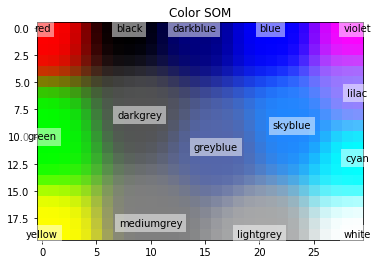

In [35]:
import matplotlib.pyplot as plt
#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

In [ ]:

def merge_phrases(matcher, doc, i, matches):
    '''
    Merge a phrase. We have to be careful here because we'll change the token indices.
    To avoid problems, merge all the phrases once we're called on the last match.
    '''
    if i != len(matches)-1:
        return None
    # Get Span objects
    spans = [(ent_id, label, doc[start : end]) for ent_id, label, start, end in matches]
    for ent_id, label, span in spans:
        span.merge(label=label, tag='NNP' if label else span.root.tag_)

In [ ]:
<p id="note1">
turns out the distinction may not be that important. (see [Levy and Goldberg (2014), Pennington et al. (2014), Österlund et al. (2015)] as referenced in https://www.gavagai.se/blog/2015/09/30/a-brief-history-of-word-embeddings/).
</p>